# Analyze A/B Test Results 

This project will assure you have mastered the subjects covered in the statistics lessons. We have organized the current notebook into the following sections: 

- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)
- [Conclusion](#conclusion)



<a id='intro'></a>
## Introduction

A/B tests are very commonly performed by data analysts and data scientists. For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.



<a id='probability'></a>
## Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline

random.seed(42)

### ToDo 1.1
Now, read in the `ab_data.csv` data. Store it in `df`. Below is the description of the data, there are a total of 5 columns:

<center>

|Data columns|Purpose|Valid values|
| ------------- |:-------------| -----:|
|user_id|Unique ID|Int64 values|
|timestamp|Time stamp when the user visited the webpage|-|
|group|In the current A/B experiment, the users are categorized into two broad groups. <br>The `control` group users are expected to be served with `old_page`; and `treatment` group users are matched with the `new_page`. <br>However, **some inaccurate rows** are present in the initial data, such as a `control` group user is matched with a `new_page`. |`['control', 'treatment']`|
|landing_page|It denotes whether the user visited the old or new webpage.|`['old_page', 'new_page']`|
|converted|It denotes whether the user decided to pay for the company's product. Here, `1` means yes, the user bought the product.|`[0, 1]`|
</center>


**a.** Read in the dataset from the `ab_data.csv` file and take a look at the top few rows here:

In [2]:
# Reading the data
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


**b.** Use the cell below to find the number of rows in the dataset.

In [3]:
# checking the number of rows
df.shape

(294478, 5)

**c.** The number of unique users in the dataset.

In [4]:
# checking the number of unique values in each column
df.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

**d.** The proportion of users converted.

In [5]:
# proportion of unique users converted
np.mean((df.groupby('user_id')['converted'].max()))

0.12104245244060237

In [6]:
# proportion of all users in the data-set converted
df['converted'].mean()

0.11965919355605512

**e.** The number of times when the "group" is `treatment` but "landing_page" is not a `new_page`.

In [7]:
# Total number of inaccurate rows in the treatment group
df.query('group == "treatment" and landing_page != "new_page"').shape[0]

1965

In [8]:
# Total number of inaccurate rows in the control group 
df.query('group == "control" and landing_page != "old_page"').shape[0]

1928

**f.** Do any of the rows have missing values?

In [9]:
# checking the missing values in each columnn
df.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

### ToDo 1.2  
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means, the `control` group users should match with `old_page`; and `treatment` group users should matched with the `new_page`. 

However, for the rows where `treatment` does not match with `new_page` or `control` does not match with `old_page`, we cannot be sure if such rows truly received the new or old wepage.  


Use **Quiz 2** in the classroom to figure out how should we handle the rows where the group and landing_page columns don't match?

**a.** Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# Remove the inaccurate rows, and store the result in a new dataframe df2

In [11]:
# the index of the inaccurate rows at the control group
control_index = np.array(df.query('group == "control" and landing_page != "old_page"').index)

# the index of the inaccurate rows at the treatment group
treatment_index = np.array(df.query('group == "treatment" and landing_page != "new_page"').index)

# the total inaccurate index rows to be remved
index_remove = np.append(control_index, treatment_index)

# checking the total number of inaccurate rows
len(index_remove)

3893

In [12]:
# Droping the inaccurate rows and saved in a new dataframe
df2 = df.drop(index = index_remove)

# checking the number of rows of the new dataframe 
df2.shape

(290585, 5)

In [13]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

### ToDo 1.3  
Use **df2** and the cells below to answer questions for **Quiz 3** in the classroom.

**a.** How many unique **user_id**s are in **df2**?

In [14]:
# number of unique users
df2['user_id'].nunique()

290584

**b.** There is one **user_id** repeated in **df2**.  What is it?

In [15]:
# the repeated user-id
rep_id = df2['user_id'].value_counts().index[0]
rep_id

773192

**c.** Display the rows for the duplicate **user_id**? 

In [16]:
# the rows of the repeated user-id
df2[df2['user_id'] == rep_id]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


**d.** Remove **one** of the rows with a duplicate **user_id**, from the **df2** dataframe.

In [17]:
# duplicated user index to remove
duplicate_index_remove = df2[df2['user_id'] == rep_id].index[0]

# removing one of the dulicated row
df2 = df2.drop(index = duplicate_index_remove)


In [18]:
# Check again if the row with a duplicate user_id is deleted or not
df2[df2['user_id'] == rep_id]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [19]:
# check if there is any repeated user-id
df2['user_id'].value_counts().max()

1

### ToDo 1.4  
Use **df2** in the cells below to answer the quiz questions related to **Quiz 4** in the classroom.

**a.** What is the probability of an individual converting regardless of the page they receive?<br><br>




In [20]:
# probability of an individual converting in the population
df2['converted'].mean()

0.11959708724499628

**b.** Given that an individual was in the `control` group, what is the probability they converted?

In [21]:
# probability of an individual converting in the control group
conv_control = df2.query('group == "control"')['converted'].mean()
conv_control

0.1203863045004612

**c.** Given that an individual was in the `treatment` group, what is the probability they converted?

In [22]:
# probability of an individual converting in the treatment group
conv_treatment = df2.query('group == "treatment"')['converted'].mean()
conv_treatment

0.11880806551510564

In [23]:
# Calculate the actual difference (obs_diff) between the conversion rates for the two groups.
obs_diff = conv_treatment - conv_control
obs_diff

-0.0015782389853555567

**d.** What is the probability that an individual received the new page?

In [24]:
# probability that an individual received the new page
(df2['landing_page'] == "new_page").mean()

0.50006194422266881

**e.** Consider your results from parts (a) through (d) above, and explain below whether the new `treatment` group users lead to more conversions.

>**The treatment group has less conversion rate than the control group by 0.16%**

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, you could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


### ToDo 2.1
For now, consider you need to make the decision just based on all the data provided.  

> Recall that you just calculated that the "converted" probability (or rate) for the old page is *slightly* higher than that of the new page (ToDo 1.4.c). 

If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should be your null and alternative hypotheses (**$H_0$** and **$H_1$**)?  

You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the "converted" probability (or rate) for the old and new pages respectively.

>**$H_0 = p_{new} \leq p_{old}$**             
>**$H_1 = p_{new} > p_{old}$** 

### ToDo 2.2 - Null Hypothesis $H_0$ Testing
Under the null hypothesis $H_0$, assume that $p_{new}$ and $p_{old}$ are equal. Furthermore, assume that $p_{new}$ and $p_{old}$ both are equal to the **converted** success rate in the `df2` data regardless of the page. So, our assumption is: <br><br>
<center>
$p_{new}$ = $p_{old}$ = $p_{population}$
</center>

In this section, you will: 

- Simulate (bootstrap) sample data set for both groups, and compute the  "converted" probability $p$ for those samples. 


- Use a sample size for each group equal to the ones in the `df2` data.


- Compute the difference in the "converted" probability for the two samples above. 


- Perform the sampling distribution for the "difference in the converted probability" between the two simulated-samples over 10,000 iterations; and calculate an estimate. 



Use the cells below to provide the necessary parts of this simulation.  You can use **Quiz 5** in the classroom to make sure you are on the right track.

**a.** What is the **conversion rate** for $p_{new}$ under the null hypothesis? 

In [25]:
# conversion rate for 𝑝_𝑛𝑒𝑤  under the null hypothesis
p_new = df2['converted'].mean()
p_new

0.11959708724499628

**b.** What is the **conversion rate** for $p_{old}$ under the null hypothesis? 

In [26]:
# conversion rate for 𝑝_𝑜𝑙𝑑  under the null hypothesis
p_old = df2['converted'].mean()
p_old

0.11959708724499628

**c.** What is $n_{new}$, the number of individuals in the treatment group? <br><br>

In [27]:
# the number of individuals in the treatment group
n_new = df2.query('group == "treatment"').shape[0]
n_new

145310

**d.** What is $n_{old}$, the number of individuals in the control group?

In [28]:
# the number of individuals in the control group
n_old = df2.query('group == "control"').shape[0]
n_old

145274

**e. Simulate Sample for the `treatment` Group**<br> 
Simulate $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>

In [29]:
# Simulate a Sample for the treatment Group
new_page_converted = np.random.choice([0, 1], size=n_new, p=[(1-p_new), p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

**f. Simulate Sample for the `control` Group** <br>
Simulate $n_{old}$ transactions with a conversion rate of $p_{old}$ under the null hypothesis. <br> Store these $n_{old}$ 1's and 0's in the `old_page_converted` numpy array.

In [30]:
# Simulate a Sample for the control Group
old_page_converted = np.random.choice([0, 1], size=n_old, p=[(1-p_old), p_old])
old_page_converted

array([0, 1, 0, ..., 0, 1, 0])

**g.** Find the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for your simulated samples from the parts (e) and (f) above. 

In [31]:
# the difference in the "converted" probability between the tow groups
new_page_converted.mean() - old_page_converted.mean()

0.00025936717038593793


**h. Sampling distribution** <br>
Re-create `new_page_converted` and `old_page_converted` and find the $(p{'}_{new}$ - $p{'}_{old})$ value 10,000 times using the same simulation process you used in parts (a) through (g) above. 

<br>
Store all  $(p{'}_{new}$ - $p{'}_{old})$  values in a NumPy array called `p_diffs`.

* **Due to long computational time with the for-loop we use `np.random.binomial` function instead to simulate 10,000 samples because of the very fast computational time compared to the loop**  

In [32]:
# Bootstrap Sampling distribution 
p_diffs = []

# the fixed varibles
p_new = df2['converted'].mean()
p_old = df2['converted'].mean()
n_new = df2.query('group == "treatment"').shape[0]
n_old = df2.query('group == "control"').shape[0]

# 10,000 sampling of the conversion rates for the treatment group  
new_page_converted = np.random.binomial(n_new, p_new, 10000) / n_new

# 10,000 sampling of the conversion rates for the control group
old_page_converted = np.random.binomial(n_old, p_old, 10000) / n_old

# sampling distripution for the difference between the two groups
p_diffs = new_page_converted - old_page_converted    

**i. Histogram**<br> 
Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.<br><br>
Also, use `plt.axvline()` method to mark the actual difference observed  in the `df2` data (recall `obs_diff`), in the chart.  



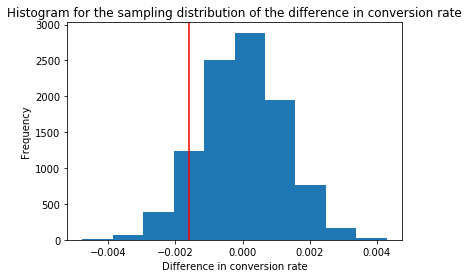

In [33]:
# Ploting the histogram
plt.hist(p_diffs);
plt.axvline(x=obs_diff, color='red');
plt.title("Histogram for the sampling distribution of the difference in conversion rate")
plt.xlabel("Difference in conversion rate")
plt.ylabel("Frequency")
plt.show()

**j.** What proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data?

In [34]:
# convert list to numpy array
p_diffs = np.array(p_diffs)

# proportion of the p_diffs are greater than the actual difference observed (P-value)
(p_diffs > obs_diff).mean()

0.90480000000000005

**k.** Please explain in words what you have just computed in part **j** above.  
 - What is this value called in scientific studies?  
 - What does this value signify in terms of whether or not there is a difference between the new and old pages? 

>* **The computed value above is the P-value** 

>* **According to the P-value = 0.909 whis is greater than the Type I error rate (0.05) we can say that we fail to reject the null hypothesis which states that there is no difference in the conversion rate between the new and old pages**



**l. Using Built-in Methods for Hypothesis Testing**<br>
We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. 

Fill in the statements below to calculate the:
- `convert_old`: number of conversions with the old_page
- `convert_new`: number of conversions with the new_page
- `n_old`: number of individuals who were shown the old_page
- `n_new`: number of individuals who were shown the new_page


In [35]:
import statsmodels.api as sm

# number of conversions with the old_page
convert_old = sum((df2['group'] == "control") & (df2['converted'] == 1))

# number of conversions with the new_page
convert_new = sum((df2['group'] == "treatment") & (df2['converted'] == 1))

# number of individuals who were shown the old_page
n_old = df2.query('group == "control"').shape[0]

# number of individuals who received new_page
n_new = df2.query('group == "treatment"').shape[0]


/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


**m.** Now use `sm.stats.proportions_ztest()` to compute your test statistic and p-value.


In [36]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old], alternative='larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


**n.** What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?<br><br>

>* **Accordingly to the computed $Z_{score} = -1.311$ which is less than the $Z_{\alpha} = 1.645$ and for for a right-tailed test we can say we fail to reject the null hypothesis**            

>* **Also the $p_{value} = 0.905$ which is higher than the type I error rate of 0.05 we can say we fail to reject the null hypothesis**

<a id='regression'></a>
### Part III - A regression approach

### ToDo 3.1 
In this final part, you will see that the result you achieved in the A/B test in Part II above can also be achieved by performing regression.<br><br> 

**a.** Since each row in the `df2` data is either a conversion or no conversion, what type of regression should you be performing in this case?

>**Logistic Regression**

**b.** The goal is to use **statsmodels** library to fit the regression model you specified in part **a.** above to see if there is a significant difference in conversion based on the page-type a customer receives. However, you first need to create the following two columns in the `df2` dataframe:
 1. `intercept` - It should be `1` in the entire column. 
 2. `ab_page` - It's a dummy variable column, having a value `1` when an individual receives the **treatment**, otherwise `0`.  

In [37]:
df2['intercept'] = 1
# encoding the group column to get the ab_page column
df2[['control', 'ab_page']]= pd.get_dummies(df2['group'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0


**c.** Use **statsmodels** to instantiate your regression model on the two columns you created in part (b). above, then fit the model to predict whether or not an individual converts. 


In [38]:
#  instantiate the regression model
logit_mod =sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])

#fit the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**d.** Provide the summary of your model below, and use it as necessary to answer the following questions.

In [39]:
#get summary statistics
results.summary2() 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-12-22 21:57 AIC:              212780.3502
No. Observations:   290584           BIC:              212801.5095
Df Model:           1                Log-Likelihood:   -1.0639e+05
Df Residuals:       290582           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9888    0.0081  -246.6690  0.0000  -2.0046  -1.9730
ab_page      -0.0150    0.0114    -1.3109  0.1899  -0.0374   0.0074
==================================================================

"""

**e.** What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  


>* **the p-value associated with ab_page variable is equal to 0.1899**        

>* **The p-value in the regression is different than we computed in the previous test because the p-value returned from the regression hypothesis are two-sided which assume that the alternative hypothesis is the parameter of the slop is not equal to 0**         

>* **while the p-value we computed previously based on one-sided hyothesis test**        
           

>* **And according to Type I error rate (0.05) we also could say we fail to reject the null hypothesis**


**f.** Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

>**Maybe the time had some influences associated with conversion, it will benefit the analysis to see if there is any relation from a specific aspects of the time that influences the conversion**

In [40]:
# checking the min and max timestamp 
df2['timestamp'].min(), df2['timestamp'].max()

('2017-01-02 13:42:05.378582', '2017-01-24 13:41:54.460509')

In [41]:
# converting the timestamp column to appicable datetime data type
df2['timestamp'] = pd.to_datetime(df2['timestamp'])

# creating days name column in the dataset
df2['Day'] = df2['timestamp'].dt.day_name()

# checking the data
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,Day
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,Saturday
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,Thursday
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,Wednesday
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,Sunday
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,Saturday


In [42]:
# encoding the Day column to get the weekend (Friday) column encoded 
df2[['weekend', 'Monday', 'Saturday', 'Sunday', 'Thursday', 'Tuesday', 'Wednesday']]= pd.get_dummies(df2['Day'])
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,control,ab_page,Day,weekend,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,1,0,Saturday,0,0,1,0,0,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,1,0,Thursday,0,0,0,0,1,0,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,0,1,Wednesday,0,0,0,0,0,0,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,0,1,Sunday,0,0,0,1,0,0,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,1,0,Saturday,0,0,1,0,0,0,0


In [43]:
#  instantiate the regression model
logit_mod =sm.Logit(df2['converted'], df2[['intercept', 'ab_page', 'weekend']])

#fit the model
results = logit_mod.fit()

#get summary statistics
results.summary2() 

Optimization terminated successfully.
         Current function value: 0.366112
         Iterations 6


<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-12-22 21:57 AIC:              212778.6601
No. Observations:   290584           BIC:              212810.3991
Df Model:           2                Log-Likelihood:   -1.0639e+05
Df Residuals:       290581           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9845    0.0084  -237.2203  0.0000  -2.0009  -1.9681
ab_page      -0.0149    0.0114    -1.3064  0.1914  -0.0373   0.0075
weekend      -0.0322    0.0168    -1.9152  0.0555  -0.0651   0.0008
==================================================================

"""

>* **As we can see from the p-value of the weekend variable had a slightly low value (0.055), But also this value is above the error rate which we can't say that the weekend had a statistical significant relationship with the conversion**

>* **As we can see that the experiment for the new page run for only 22 days which is not enough time period to make decision about whether the new page has higher or lower conversion rate**


>* **Also there are other factors may biased the results such as: Novelty Effect and Change Aversion**

>* **And adding additional variables to the regression model may also benefit the analysis if the Multicollinearity problems avoided which is mainly appears if the X-variables are quanitative data and in our case the predictors variables are caegorical data till now which will not make any problem until this point**

**g. Adding countries**<br> 
Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives in. 

1. You will need to read in the **countries.csv** dataset and merge together your `df2` datasets on the appropriate rows. You call the resulting dataframe `df_merged`. [Here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.join.html) are the docs for joining tables. 

2. Does it appear that country had an impact on conversion?  To answer this question, consider the three unique values, `['UK', 'US', 'CA']`, in the `country` column. Create dummy variables for these country columns. 


 Provide the statistical output as well as a written response to answer this question.

In [44]:
# Read the countries.csv
df_countries = pd.read_csv('countries.csv')
df_countries.head()

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK
3,711597,UK
4,710616,UK


In [45]:
# Join with the df2 dataframe
df_merged = df_countries.merge(df2, left_on='user_id', right_on='user_id', how='inner')
df_merged.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,control,ab_page,Day,weekend,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,Saturday,0,0,1,0,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,Monday,0,1,0,0,0,0,0
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,Monday,0,1,0,0,0,0,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,Sunday,0,0,0,1,0,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,Monday,0,1,0,0,0,0,0


In [46]:
# Create the necessary dummy variables

# encoding the country column to converte the categorical data
df_merged[['CA', 'UK', 'US']]= pd.get_dummies(df_merged['country'])
df_merged.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,control,ab_page,Day,weekend,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,CA,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,Saturday,0,0,1,0,0,0,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,Monday,0,1,0,0,0,0,0,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,Monday,0,1,0,0,0,0,0,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,Sunday,0,0,0,1,0,0,0,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,Monday,0,1,0,0,0,0,0,0,1,0


In [47]:
#  instantiate the regression model
logit_mod =sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK']])

#fit the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [48]:
#get summary statistics
results.summary2() 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-12-22 21:57 AIC:              212781.1253
No. Observations:   290584           BIC:              212823.4439
Df Model:           3                Log-Likelihood:   -1.0639e+05
Df Residuals:       290580           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9893    0.0089  -223.7628  0.0000  -2.0067  -1.9718
ab_page      -0.0149    0.0114    -1.3069  0.1912  -0.0374   0.0075
CA           -0.0408    0.0269    -1.5161  0.1295  -0.0934   0.0119
UK            0.0099    0.0133     0.7433  0.4573  -0.0162   0.0359
==================================================================

"""

>* **After checking the p-value for the counties variable it seems that the countries & the new page have not any statistically significant relationships with the conversion, because their p-value are less than the error rate**

**h. Fit your model and obtain the results**<br> 
Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if are there significant effects on conversion.  **Create the necessary additional columns, and fit the new model.** 


Provide the summary results (statistical output), and your conclusions (written response) based on the results. 


In [49]:
# checking the dataset
df_merged.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,control,ab_page,Day,weekend,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday,CA,UK,US
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,Saturday,0,0,1,0,0,0,0,0,1,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,Monday,0,1,0,0,0,0,0,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,Monday,0,1,0,0,0,0,0,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,Sunday,0,0,0,1,0,0,0,0,1,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,Monday,0,1,0,0,0,0,0,0,1,0


In [50]:
# creating the interactive variables by multiplying the encoded counties variable with the treatment encoded variable 
df_merged['CA_ab_page'] = df_merged['CA'] * df_merged['ab_page']
df_merged['UK_ab_page'] = df_merged['UK'] * df_merged['ab_page']
df_merged['US_ab_page'] = df_merged['US'] * df_merged['ab_page']

# checking the dataset
df_merged.head()

,user_id,country,timestamp,group,landing_page,converted,intercept,control,ab_page,Day,...,Sunday,Thursday,Tuesday,Wednesday,CA,UK,US,CA_ab_page,UK_ab_page,US_ab_page
0,834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,1,0,Saturday,...,0,0,0,0,0,1,0,0,0,0
1,928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,0,1,Monday,...,0,0,0,0,0,0,1,0,0,1
2,822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,0,1,Monday,...,0,0,0,0,0,1,0,0,1,0
3,711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,1,0,Sunday,...,1,0,0,0,0,1,0,0,0,0
4,710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,0,1,Monday,...,0,0,0,0,0,1,0,0,1,0


In [51]:
# Fit your model, and summarize the results

#  instantiate the regression model
logit_mod =sm.Logit(df_merged['converted'], df_merged[['intercept', 'ab_page', 'CA', 'UK', 'CA_ab_page', 'UK_ab_page']])

#fit the model
results = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [52]:
#get summary statistics
results.summary2() 

<class 'statsmodels.iolib.summary2.Summary'>
"""
                          Results: Logit
==================================================================
Model:              Logit            No. Iterations:   6.0000     
Dependent Variable: converted        Pseudo R-squared: 0.000      
Date:               2022-12-22 21:57 AIC:              212782.6602
No. Observations:   290584           BIC:              212846.1381
Df Model:           5                Log-Likelihood:   -1.0639e+05
Df Residuals:       290578           LL-Null:          -1.0639e+05
Converged:          1.0000           Scale:            1.0000     
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
intercept    -1.9865    0.0096  -206.3440  0.0000  -2.0053  -1.9676
ab_page      -0.0206    0.0137    -1.5052  0.1323  -0.0473   0.0062
CA           -0.0175    0.0377    -0.4652  0.6418  -0.0914   0.0563
UK           -0.0057    0.0188    -0.3057  0.7598  -0.0426   0.0311
CA_ab_page   -0.0469    0.0538    -0.8718  0.3833  -0.1523   0.0585
UK_ab_page    0.0314    0.0266     1.1807  0.2377  -0.0207   0.0835
==================================================================

"""

* **From the above interaction analysis between countries & the new page with the conversion we can say that we do not have any statistically significant relationships with the conversion, because their p-value are less than the error rate**


<a id='conclusion'></a>
## Conclusion


>* **And finally we sholud increase the time period of the experiment in order to be able to make accurate analysis**

>* **However that our results haven't statistical significant these findings might not be practically significant at all due to short time period of the experiment, Also there are other factors may biased the results such as: Novelty Effect and Change Aversion**